<a href="https://colab.research.google.com/github/HasibAlMuzdadid/Machine-Learning-and-Deep-Learning-Projects/blob/main/art%20generation%20%5Bneural%20style%20transfer%5D/art_generation_using_neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Art Generation**

We will implement art generation using **Neural Style Transfer**, an algorithm created by [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576).

**Neural Style Transfer (NST)** is one of the most fun and interesting optimization techniques in deep learning. It merges two images, namely: a ***content image (C)*** and a ***style image (S)*** to create a ***generated image (G)***. The generated image G combines the "content" of the image C with the "style" of image S. 

Here we are going to combine the Louvre museum in Paris (content image C) with the impressionist style of Claude Monet (content image S) to generate the resultant new image.


In [ ]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint

### **Transfer Learning**


**Neural Style Transfer (NST)** uses a previously trained convolutional network and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

We will be using the the epynomously named VGG network from the [original NST paper](https://arxiv.org/abs/1508.06576) published by the Visual Geometry Group at University of Oxford in 2014. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database and has learnt to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

 

In [ ]:
# loading parameters from the VGG model

# tf.random.set_seed(272) 
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights="/content/drive/MyDrive/colab files/pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5")

vgg.trainable = False
pp.pprint(vgg)

### **Neural Style Transfer (NST)**

We will build the Neural Style Transfer (NST) algorithm in three steps:

- First, we will build the content cost function $J_{content}(C,G)$
- Second, we will build the style cost function $J_{style}(S,G)$
- Finally, we'll put it all together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. Exciting!


#### **Computing Content Cost**
#### ***Making Generated Image G Matching Content of Image C***

One goal we should aim for when performing NST is for the content in generated image G to match the content of image C. For doing so, we'll need an understanding of shallow versus deep layers :

* The shallower layers of a ConvNet tend to detect lower-level features such as *edges* and *simple textures*.
* The deeper layers tend to detect higher-level features such as more *complex textures* and *object classes*. 

#### ***To choose a "middle" activation layer $a^{[l]}$ :***
We need the "generated" image G to have similar content as the input image C. Suppose we have chosen some layer's activations to represent the content of an image. 
* In practice, we'll get the most visually pleasing results if we choose a layer in the **middle** of the network that is neither too shallow nor too deep. This ensures that the network detects both higher-level and lower-level features.
* We can experiment with using different layers to see how the results vary!

#### ***To forward propagate image "C:"***
* Setting the image C as the input to the pretrained VGG network and running forward propagation.  
* Let $a^{(C)}$ be the hidden layer activations in the layer we have chosen.  This will be an $n_H \times n_W \times n_C$ tensor.

#### ***To forward propagate image "G":***
* Repeating this process with the image G: Setting G as the input and running forward progation. 
* Letting $a^{(G)}$ be the corresponding hidden layer activation. 

Here, the content image C will be the picture of the Louvre Museum in Paris. 

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings against a sunny sky with a few clouds.


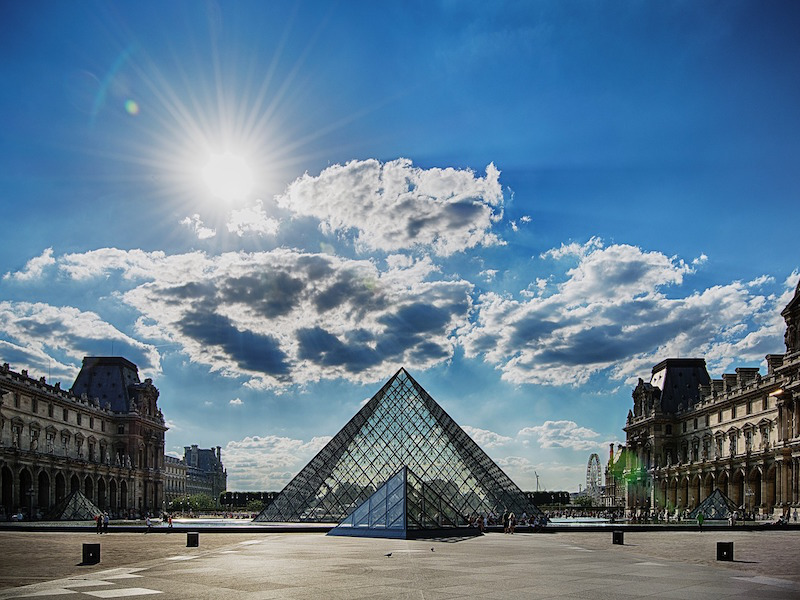

In [ ]:
content_image = Image.open("/content/drive/MyDrive/colab files/images/louvre.jpg")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings against a sunny sky with a few clouds.")
content_image

#### ***Content Cost Function $J_{content}(C,G)$***
One goal we should aim for when performing NST is for the content in generated image G to match the content of image C. A method to achieve this is to calculate the content cost function which will be defined as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2 $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer we have chosen and appear in a normalization term in the cost. 
* For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix.
* Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when we do need to carry out a similar operation later for computing the style cost $J_{style}$.



**Implementation Compute Content Cost**



**Instructions :** 

`a_G`: hidden layer activations representing content of the image G
<br>
`a_C`: hidden layer activations representing content of the image C 

The 3 steps to implement this function are:
1. Retrieve dimensions from `a_G`: 
    - To retrieve dimensions from a tensor `X`, use: `X.get_shape().as_list()`
2. Unroll `a_C` and `a_G` 
    - we'll likely want to use these functions: [tf.transpose](https://www.tensorflow.org/api_docs/python/tf/transpose) and [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape).
3. Compute the content cost:
    - we'll likely want to use these functions: [tf.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [tf.square](https://www.tensorflow.org/api_docs/python/tf/square) and [tf.subtract](https://www.tensorflow.org/api_docs/python/tf/subtract).
    
    
 **Additional Tips for "Unrolling"**
* To unroll the tensor, we want the shape to change from $(m,n_H,n_W,n_C)$ to $(m, n_H \times n_W, n_C)$.
* `tf.reshape(tensor, shape)` takes a list of integers that represent the desired output shape.
* For the `shape` parameter, a `-1` tells the function to choose the correct dimension size so that the output tensor still contains all the values of the original tensor.
* So `tf.reshape(a_C, shape=[m, n_H * n_W, n_C])` gives the same result as `tf.reshape(a_C, shape=[m, -1, n_C])`.
* If we prefer to re-order the dimensions, we can use `tf.transpose(tensor, perm)`, where `perm` is a list of integers containing the original index of the dimensions. 
* For example, `tf.transpose(a_C, perm=[0,3,1,2])` changes the dimensions from $(m, n_H, n_W, n_C)$ to $(m, n_C, n_H, n_W)$.
<!-- * There is more than one way you can unroll a tensor.  -->
* Again, note that we don't necessarily need `tf.transpose` to 'unroll' the tensors in this case but this is a useful function to practice and understand for other situations that we'll encounter.


In [ ]:
# compute content cost

def compute_content_cost(content_output, generated_output):
    
    # Arguments:
    # a_C -> tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    # a_G -> tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    # Returns: 
    # J_content -> scalar that we compute using equation above.
    


    a_C = content_output[-1]
    a_G = generated_output[-1]
        
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G 
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_C, shape=[m, -1 , n_C])
    a_G_unrolled =  tf.reshape(a_G, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_G, shape=[m, -1 , n_C])
    
    # compute the cost with tensorflow 
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)
    
   
    return J_content

#### **Computing Style Cost**

We will use the following style image. 

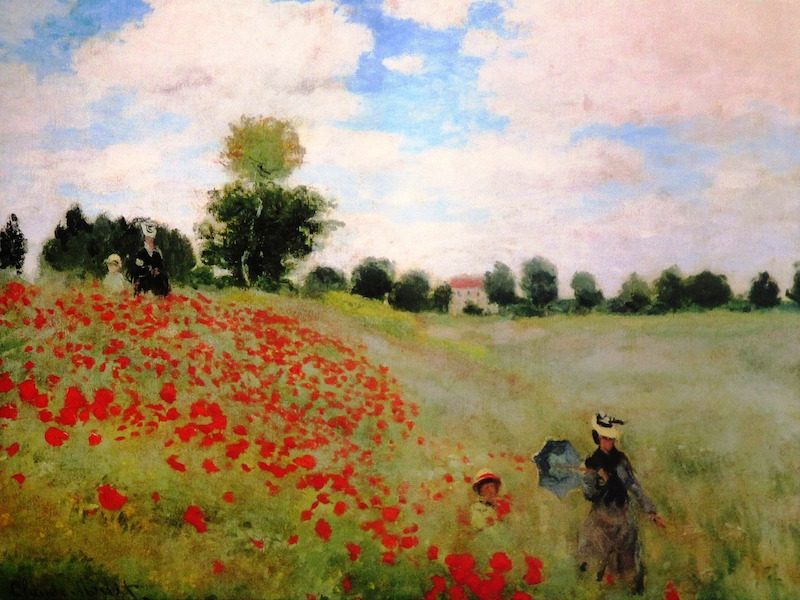

In [ ]:
example = Image.open("/content/drive/MyDrive/colab files/images/monet_800600.jpg")
example

#### **Style Matrix**

#### ***Gram Matrix***
* The style matrix is also called a "Gram matrix". 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, we will expect them to have a large dot product and thus for $G_{ij}$ to be large. 

#### ***Two Meanings of Variable $G$***
* Note that there is an unfortunate collision in the variable names used here. Following the common terminology used in the literature: 
    * $G$ is used to denote the Style matrix (or Gram matrix) 
    * $G$ also denotes the generated image. 
* For the sake of clarity, here $G_{gram}$ will be used to refer to the Gram matrix and $G$ to denote the generated image.

#### ***Computing Gram matrix $G_{gram}$***
We will compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:


$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### ***$G_{(gram)ij}$: Correlation***
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)ij}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### ***$G_{(gram)ii}$: Prevalence of Patterns or Textures***
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$) as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 



**Implementation Gram Matrix**
* Using TensorFlow implementing a function that computes the Gram matrix of a matrix A. 
    * The formula is: The gram matrix of A is ${\displaystyle G_{A} = AA^T  }$. 
* We can use these functions: [matmul](https://www.tensorflow.org/api_docs/python/tf/matmul) and [transpose](https://www.tensorflow.org/api_docs/python/tf/transpose).

In [ ]:
# gram_matrix

def gram_matrix(A):

    # Argument:
    # A -> matrix of shape (n_C, n_H*n_W)
    
    # Returns:
    # GA -> Gram matrix of A, of shape (n_C, n_C)
 


    GA = tf.matmul(A, tf.transpose(A))


    return GA

#### **Style Cost**

We now know how to calculate the Gram matrix. Our next goal is to minimize the distance between the Gram matrix of the "style" image S and the Gram matrix of the "generated" image G. 
* For now, we will use only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2 $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* Make sure we remember that, this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$

**Implementation Compute Layer Style Cost**

Computing the style cost for a single layer. 

**Instructions :** 

The steps to implement this function are:
1. Retrieve dimensions from the hidden layer activations a_G: 
    - To retrieve dimensions from a tensor X, using: `X.get_shape().as_list()`
2. Unroll the hidden layer activations a_S and a_G into 2D matrices. 
    - We may use [tf.transpose](https://www.tensorflow.org/api_docs/python/tf/transpose) and [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape).
3. Compute the Style matrix of the images S and G. (Using the function we have previously written.) 
4. Compute the Style cost:
    - We may find [tf.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [tf.square](https://www.tensorflow.org/api_docs/python/tf/square) and [tf.subtract](https://www.tensorflow.org/api_docs/python/tf/subtract) useful.
    
    
**Additional Tips**
* Since the activation dimensions are $(m, n_H, n_W, n_C)$ whereas the desired unrolled matrix shape is $(n_C, n_H*n_W)$, the order of the filter dimension $n_C$ is changed.  So `tf.transpose` can be used to change the order of the filter dimension.


In [ ]:
# compute layer style cost

def compute_layer_style_cost(a_S, a_G):

    # Arguments:
    # a_S -> tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    # a_G -> tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    # Returns: 
    # J_style_layer -> tensor representing a scalar value, style cost defined above 
   

    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W) 
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))  # OR a_S = tf.transpose(tf.reshape(a_S, shape=[ n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss 
    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))

    
    return J_style_layer

#### **Style Weights**

* So far we have captured the style from only one layer. 
* we'll get better results if we "merge" style costs from several different layers. 
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* We can experiment with different weights to see how it changes the generated image $G$.
* By default, giving each layer equal weight and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

In [ ]:
# listing layer names
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Let's get a look at the output of a layer `block5_conv4`. We will later define this as the content layer which will represent the image.

In [ ]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

Now choosing layers to represent the style of the image and assigning style costs

In [ ]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

We can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


**Implementation Compute Style Cost**


**Instructions:**
* A compute_style_cost() function has already been implemented. 
* It calls our `compute_layer_style_cost()` several times and weights their results using the values in `STYLE_LAYERS`. 


**Description of `compute_style_cost`**

For each layer :
* Selecting the activation (the output tensor) of the current layer.
* Getting the style of the style image "S" from the current layer.
* Getting the style of the generated image "G" from the current layer.
* Computing the "style cost" for the current layer
* Adding the weighted style cost to the overall style cost (J_style)

Once we're done with the loop :  
* Returning the overall style cost.

In [ ]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    
    # Arguments:
    # style_image_output -> our tensorflow model
    # generated_image_output 
    # STYLE_LAYERS -> A python list containing the names of the layers we would like to extract style from a coefficient for each of them
    
    # Returns: 
    # J_style -> tensor representing a scalar value, style cost defined above

    
    # initializing the overall style cost
    J_style = 0

    # Setting a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image which must not be used.
    a_S = style_image_output[:-1]

    # Setting a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Computing style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Adding weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer


    return J_style

The deeper layers capture higher-level concepts and the features in the deeper layers are less localized in the image relative to each other. So if one wants the generated image to softly follow the style image, try choosing larger weights for deeper layers and smaller weights for the first layers. In contrast, if one wants the generated image to strongly follow the style image, try choosing smaller weights for deeper layers and larger weights for the first layers.




 

#### **Total Cost to Optimize**

We will create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$


 **Implemetation Total Cost**

Implementing the total cost function which includes both the content cost and the style cost.

In [ ]:
# total cost
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    
    # Arguments:
    # J_content -> content cost coded above
    # J_style -> style cost coded above
    # alpha -> hyperparameter weighting the importance of the content cost
    # beta -> hyperparameter weighting the importance of the style cost
    
    # Returns:
    # J -> total cost as defined by the formula above


    J = alpha * J_content + beta * J_style
    

    return J

### **Solving the Optimization Problem**

We will get to put everything together to implement Neural Style Transfer now.

#### **Loading Content Image**
The following code will load, reshape and normalize the "content" image C.

(1, 400, 400, 3)


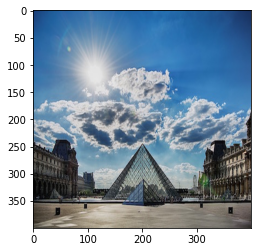

In [ ]:
content_image = np.array(Image.open("/content/drive/MyDrive/colab files/images/louvre_small.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

#### **Loading Style Image**
Now load, reshape and normalize the "style" image (Claude Monet's painting).

(1, 400, 400, 3)


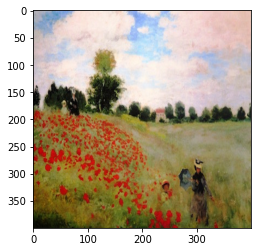

In [ ]:
style_image =  np.array(Image.open("/content/drive/MyDrive/colab files/images/monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

#### **Randomly Initializing Generated Image**
Now, we get to initialize the "generated" image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. 

(1, 400, 400, 3)


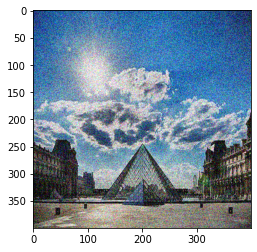

In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

#### **Loading Pre-trained VGG19 Model**
As explained before defining a function which loads the VGG19 model and returns a list of the outputs for the middle layers.

In [ ]:
def get_layer_outputs(vgg, layer_names):
    # Creates a vgg model that returns a list of intermediate output values.
    
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    
    return model

In [ ]:
# define the content layer and build the model

content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [ ]:
# Save the outputs for the content and style layers in separate variables

content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder


#### **Compute Total Cost**


**Computing the Content Image Encoding (a_C)**

For computing the content cost, we will encode our content image using the appropriate hidden layer activations. Setting this encoding to the variable `a_C`. Later we will need to do the proper with the generated image by setting the variable `a_G` to be the appropriate hidden layer activations.  

Setting `a_C` to be the tensor giving the hidden layer activation for layer "block5_conv4" using the content image.

In [ ]:
# Assign the content image to be the input of the VGG model  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

**Computing the Style Image Encoding (a_S)** 

Setting `a_S` to be the tensor giving the hidden layer activation for `STYLE_LAYERS` using our style image.

In [ ]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [ ]:
# helper functions needed to display the images generated by the style transfer model

def clip_0_1(image):
    # Truncate all the pixels in the tensor to be between 0 and 1
    
    # Arguments:
    # image -> Tensor
    # J_style -> style cost coded above

    # Returns:
    # Tensor

    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


def tensor_to_image(tensor):
    # Converts the given tensor into a PIL image
    
    # Arguments:
    # tensor -> Tensor
    
    # Returns:
    # Image: A PIL image

    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)


**Train Step** 

Implementing train_step() function for transfer learning

* Using the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) to minimize the total cost `J`.
* Using a learning rate of 0.01  
* We will use [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) to update the image. 
* Within the tf.GradientTape():
   * Computing the encoding of the generated image using vgg_model_outputs. Assing the result to a_G.
   * Computing the total cost J using the global variables a_C, a_S and the local a_G
   * Using `alpha = 10` and `beta = 40`.

In [ ]:
# train step

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function we must use the precomputed encoded images a_S and a_C
        
        # Compute a_G as the vgg_model_outputs for the current generated image
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G)

        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        
        # Compute the total cost
        J = total_cost(J_content, J_style,alpha = 10, beta = 40)
                

    return J

**Train The Model**

Generating an artistic image. It should take about 3min on a GPU for 2500 iterations. Neural Style Transfer is generally trained using GPUs.

If we increase the learning rate we can speed up the style transfer but often at the cost of quality.

Epoch 0


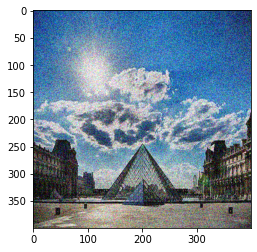

Epoch 250


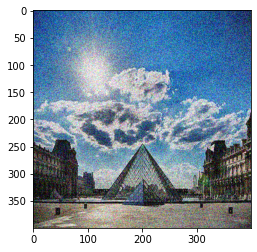

Epoch 500


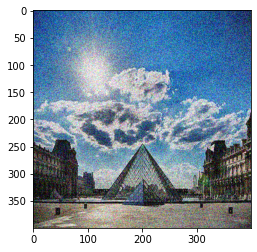

Epoch 750


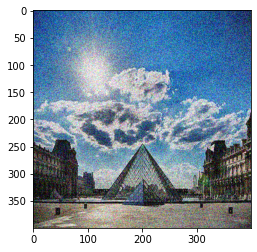

Epoch 1000


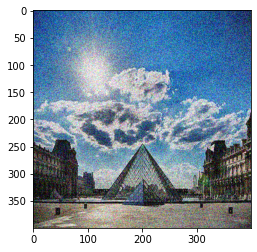

Epoch 1250


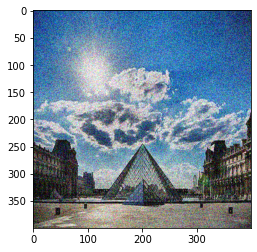

Epoch 1500


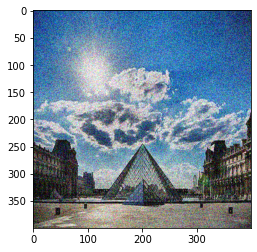

Epoch 1750


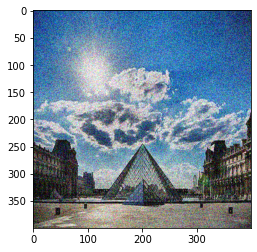

Epoch 2000


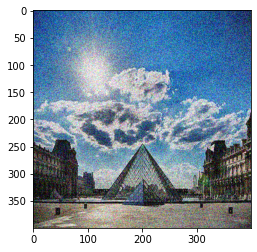

Epoch 2250


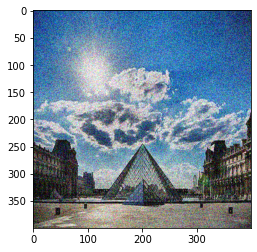

Epoch 2500


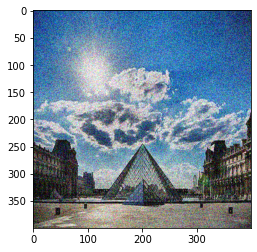

In [ ]:
# show the generated image at some epochs

epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i}")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        # image.save(f"/content/drive/MyDrive/colab files/output/generated_image_{i}.jpg")
        plt.show() 

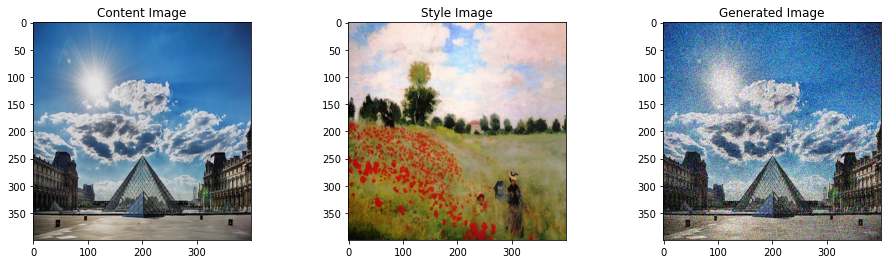

In [ ]:
# Show the 3 images in a row

fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text("Content Image")

ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text("Style Image")

ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])

ax.title.set_text("Generated Image")
plt.show()